<h1>Моделирование стоимости под риском (VaR) -- параметрический метод</h1>

<p>Разработано Драчуком А. для The Foundation</p>
<a href="https://t.me/LYFTN">Следите за нами в Телеграм</a>

<h3>Импортируем необходимые библиотеки</h3>

In [89]:
import numpy as np        #библиотека для работы с массивами и матрицами
import pandas as pd        #библитека для работы с данными
import datetime as dt        #библиотека для работы с временными рядами
import yfinance as yf        #библиотека для работы с данными с Yahoo Finance
import matplotlib.pyplot as plt        #импорт модуля для формирования графиков из библиотеки для визуализации данных
from scipy.stats import norm        #импорт модуля статистических функций из библиотеки научных функций

<h3>Задаем глубину фактических данных для анализа</h3>

In [90]:
years = 15        #указываем кол-во лет для анализа

endDate = dt.datetime.now()        #задаем конечную дату -- текущий момент времени
startDate = endDate - dt.timedelta(days = 365 * years)        #начальная дата: текущий момент времени - кол-во лет

<h3>Формируем массив тикеров ценных бумаг, из которых формируем портфель</h3>

In [91]:
#SPY -- SPDR S&P 500 ETF Trust
#BND -- Vanguard Total Bond Market Index Fund 
#GLD -- SPDR Gold Shares
#QQQ -- Invesco QQQ Trust
#VTI -- Vanguard Total Stock Market Index Fund ETF Shares 
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [92]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Adj Close']
    
print(adj_close_df)        #проверяем корректность выгрузки

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2009-06-01   71.499710  50.047081   95.730003   31.808889   36.024342
2009-06-02   71.560059  50.236347   96.360001   31.852591   36.168518
2009-06-03   70.654732  50.406013   94.410004   31.756432   35.728451
2009-06-04   71.318619  50.092812   96.230003   32.114830   36.085052
2009-06-05   71.333717  49.753468   93.709999   32.149765   36.016777
...                ...        ...         ...         ...         ...
2024-05-20  530.059998  71.739998  224.559998  454.910004  262.570007
2024-05-21  531.359985  71.889999  224.229996  455.799988  263.109985
2024-05-22  529.830017  71.800003  220.110001  455.709991  262.220001
2024-05-23  525.960022  71.589996  215.720001  453.660004  259.989990
2024-05-24  529.440002  71.669998  215.919998  457.950012  261.869995

[3773 rows x 5 columns]


<h3>Преобразовываем массив дневных цен в массив дневных доходностей</h3>

In [93]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))        #рассчитываем натуральный логарифм дневной доходности ценных бумаг
log_returns = log_returns.dropna()        #удаляем строки со значениями NaN 

print(log_returns)        #проверяем массив

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2009-06-02  0.000844  0.003775  0.006559  0.001373  0.003994
2009-06-03 -0.012732  0.003372 -0.020444 -0.003023 -0.012242
2009-06-04  0.009352 -0.006233  0.019094  0.011223  0.009931
2009-06-05  0.000212 -0.006797 -0.026536  0.001087 -0.001894
2009-06-08 -0.004134 -0.002101 -0.001602 -0.002994 -0.002742
...              ...       ...       ...       ...       ...
2024-05-20  0.001151 -0.000975  0.004016  0.006949  0.001029
2024-05-21  0.002450  0.002089 -0.001471  0.001954  0.002054
2024-05-22 -0.002883 -0.001253 -0.018545 -0.000197 -0.003388
2024-05-23 -0.007331 -0.002929 -0.020146 -0.004509 -0.008541
2024-05-24  0.006595  0.001117  0.000927  0.009412  0.007205

[3772 rows x 5 columns]


<h3>Рассчитываем веса для равновесного инвестиционого портфеля</h3>

In [94]:
weights = np.array([1/len(tickers)] * len(tickers))        #формируем массив из одинаковых весов

print(weights)        #проверяем веса

[0.2 0.2 0.2 0.2 0.2]


<h3>Определяем историческую дневную доходность равновесного портфеля</h3>

In [95]:
historical_returns = (log_returns * weights).sum(axis = 1)        #доходность портфеля в конкретный день = сумма взвешенных доходностей инструментов за этот день

print(historical_returns)        #проверяем результат

Date
2009-06-02    0.003309
2009-06-03   -0.009014
2009-06-04    0.008674
2009-06-05   -0.006786
2009-06-08   -0.002715
                ...   
2024-05-20    0.002434
2024-05-21    0.001415
2024-05-22   -0.005253
2024-05-23   -0.008691
2024-05-24    0.005051
Length: 3772, dtype: float64


<h3>Находим доходность портфеля на рассматриваемом горизонте расчета</h3>

In [96]:
days = 5        #кол-во дней, для которого рассчитывается стоимость под риском

range_returns = historical_returns.rolling(window = days).sum()       #методом rolling() мы задаем скользящее окно (window), равное кол-ву дней (days), для которого рассчитывается доходность. Для сборки массива суммируем значения 
range_returns = range_returns.dropna()        #удаляем строки со значениями NaN 

print(range_returns)        #проверяем результат -- поскольку указали окно в 5 дней, кол-во значений должно быть на (5-1) меньше, чем кол-во значений дневной доходности

Date
2009-06-08   -0.006532
2009-06-09   -0.005122
2009-06-10    0.001740
2009-06-11   -0.004241
2009-06-12   -0.000436
                ...   
2024-05-20    0.020487
2024-05-21    0.016459
2024-05-22   -0.000633
2024-05-23   -0.006851
2024-05-24   -0.005044
Length: 3768, dtype: float64


<h3>Находим значения доходности инвестиционного портфеля в долларах</h3>

In [97]:
portfolio_value = 1000000        #задаем значение стоимости порфтеля 
range_returns_dollar = range_returns * portfolio_value        #находим значения доходностей в долларах

print(range_returns_dollar)        #проверяем результат

Date
2009-06-08    -6531.752566
2009-06-09    -5121.632019
2009-06-10     1739.898092
2009-06-11    -4240.693891
2009-06-12     -435.871108
                  ...     
2024-05-20    20487.256332
2024-05-21    16458.704082
2024-05-22     -633.294888
2024-05-23    -6851.114158
2024-05-24    -5044.240320
Length: 3768, dtype: float64


<h3>Находим ковариационную матрицу и риск равновесного портфеля</h3>

In [98]:
#функция риска портфеля
def standard_deviation(weights, cov_matrix): 
        variance = weights.T @ cov_matrix @ weights 
        return np.sqrt(variance)

In [99]:
#формируем ковариационную матрицу
cov_matrix = log_returns.cov() * 252        #рассчитываем ковариационную матрицу для годового исчисления

print(cov_matrix)        #проверяем результат

          SPY       BND       GLD       QQQ       VTI
SPY  0.029679 -0.000063  0.001762  0.032622  0.030293
BND -0.000063  0.002318  0.002159  0.000162 -0.000011
GLD  0.001762  0.002159  0.024366  0.001971  0.001913
QQQ  0.032622  0.000162  0.001971  0.041654  0.033344
VTI  0.030293 -0.000011  0.001913  0.033344  0.031185


In [100]:
portfolio_std_dev = standard_deviation(weights, cov_matrix)        #находим риск равновесного портфеля

print(portfolio_std_dev)

0.11619058481371003


<h3>Формируем массив значений доверительного интервала</h3>

In [101]:
confidence_levels = [0.90, 0.95, 0.99]

<h3>Рассчитываем VaR для разных значений доверительного интервала</h3>

In [102]:
VaRs = []          #создаем пустой массив VaR, в который будем записывать результаты расчетов

for cl in confidence_levels:
    VaR = portfolio_value * portfolio_std_dev * norm.ppf(cl) * np.sqrt(days/252)
    VaRs.append(VaR)
    

print(VaRs)        #проверяем результат

[20974.506673451426, 26920.487870250876, 38074.15973004875]


<h3>Визуализируем результаты оценки VaR параметрическим методом в таблицу и на график</h3>

Доверительный интервал         Стоимость под риском (VaR)
------------------------------------------------------------
          90%:                      $ 20,974.51
          95%:                      $ 26,920.49
          99%:                      $ 38,074.16




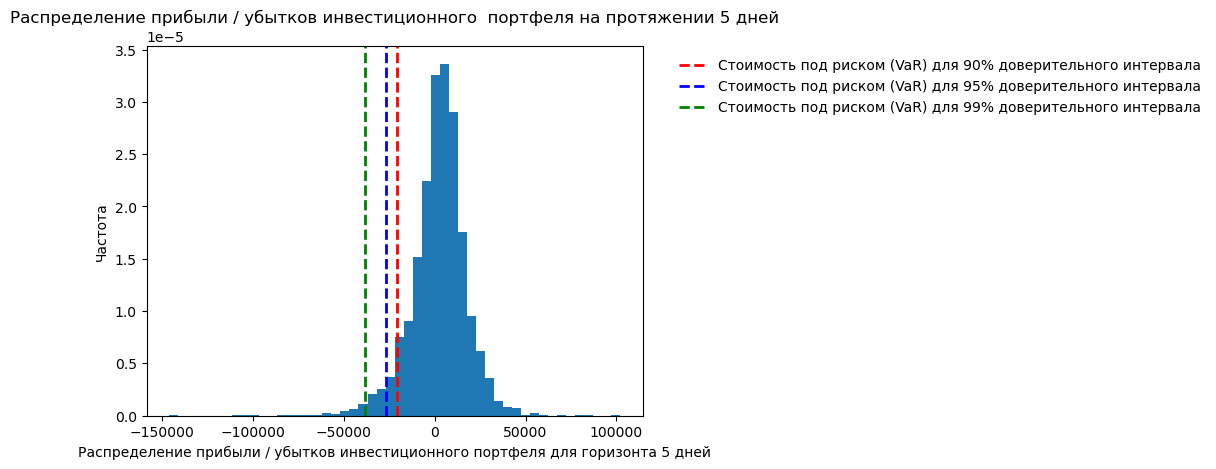

In [103]:
#формируем таблицу
print('\033[1m' + f'{"Доверительный интервал":<30} {"Стоимость под риском (VaR)": <20}')
print('-' * 60)


for cl, VaR in zip(confidence_levels, VaRs):
    print('\033[0m' + f'{"":<5} {cl * 100:>6.0f}%: {"":<20} ${VaR:>10,.2f}')

print('\n')
    
#формируем график
colors = ['r', 'b', 'g']        #задаем массив цветов, чтобы линии VaR отличались цветом для разных доверительных интервалов

plt.hist(range_returns_dollar, bins = 50, density = True)
plt.xlabel(f'Распределение прибыли / убытков инвестиционного портфеля для горизонта {days} дней')
plt.ylabel('Частота')
plt.title(label=f'Распределение прибыли / убытков инвестиционного  портфеля на протяжении {days} дней')

for cl, VaR, cr in zip(confidence_levels, VaRs, colors):
    plt.axvline(x = -VaR, color=f'{cr}', linestyle='dashed', linewidth=2, label = f'Стоимость под риском (VaR) для {cl:.0%} доверительного интервала')
   
plt.legend(loc='upper center', bbox_to_anchor=(1.6, 1.0), frameon=False, shadow=False)
plt.show()